## Imports

In [95]:
%load_ext autoreload
%autoreload 2

import os 
import sys
sys.path.append('./..')
import zipfile
import tarfile

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from dynaphos import utils
from dynaphos import cortex_models
from dynaphos.simulator import GaussianSimulator as PhospheneSimulator

from scipy.ndimage import gaussian_filter1d

sys.path.append('../data/EGTEA/Gaze_Data/gaze_data')
from gaze_io_sample import parse_gtea_gaze

from phosphene.uniformity import DynamicAmplitudeNormalizer
from components.SeparableModulated2d import SeparableModulatedConv2d
from phosphene.density import VisualFieldMapper

import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# GTEA Gaze+ Dataset
EGTEA Gaze+ is by far **the largest and most comprehensive** dataset for First Person Vision (**FPV**), with an emphasis on FPV action recognition and gaze estimation. The dataset comes with first person videos, gaze tracking data, densely annotated action labels and sparsely annotated hand masks. 

In [96]:
# # Define the root directory where all the zips are located
# root_dir = "../data/EGTEA"  # Replace with the path to your EGTEA folder

# # Walk through all subdirectories and extract zip files
# for subdir, dirs, files in os.walk(root_dir):
#     for file in files:
#         if file.endswith(".zip"):
#             zip_path = os.path.join(subdir, file)
#             extract_to = subdir  # Extract to the same directory as the zip file
            
#             print(f"Extracting {zip_path} to {extract_to}...")
#             with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#                 zip_ref.extractall(extract_to)
#             print(f"Finished extracting {file}")

# # Define the root directory where all the tar files are located
# root_dir = "../data/EGTEA"  # Replace with the path to your EGTEA folder

# # Walk through all subdirectories and extract tar files
# for subdir, dirs, files in os.walk(root_dir):
#     for file in files:
#         if file.endswith(".tar"):  # Check for tar files
#             tar_path = os.path.join(subdir, file)
#             extract_to = subdir  # Extract to the same directory as the tar file
            
#             print(f"Extracting {tar_path} to {extract_to}...")
#             with tarfile.open(tar_path, 'r') as tar_ref:
#                 tar_ref.extractall(extract_to)
#             print(f"Finished extracting {file}")

In [97]:
file_name = "OP01-R01-PastaSalad"

# Path to the gaze data file
gaze_data_path = f"../data/EGTEA/Gaze_Data/gaze_data/gaze_data/{file_name}.txt"
gaze_data = parse_gtea_gaze(gaze_data_path)
gaze_data.shape

# Path to the video file
video_path = f"../data/EGTEA/Raw_Videos/{file_name}.mp4"

Frame 50: Gaze Point (0.57, 0.56), Gaze Type: 1


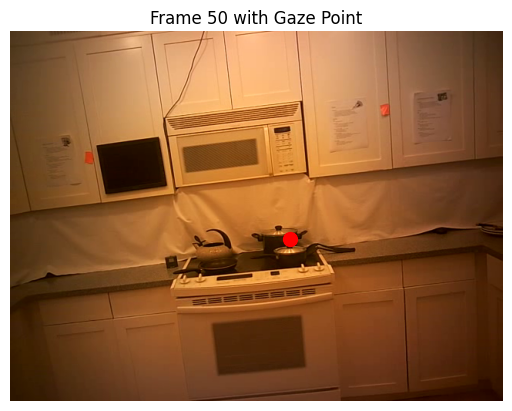

In [98]:
# Index of the frame to analyze
frame_i = 50

# Open the video
cap = cv2.VideoCapture(video_path)

# Get the gaze data for the specific frame
gaze_point = gaze_data[frame_i, :]

if gaze_point[2] == 4:  # Gaze truncated (out of bounds)
    print(f"Frame {frame_i}: Gaze point out of bounds.")
else:
    gaze_x, gaze_y = gaze_point[0], gaze_point[1]  # Normalized coordinates
    gaze_type = int(gaze_point[2])
    print(f"Frame {frame_i}: Gaze Point ({gaze_x:.2f}, {gaze_y:.2f}), Gaze Type: {gaze_type}")

# Set the video to the desired frame
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_i)
ret, frame = cap.read()

if ret:
    # Denormalize gaze coordinates to image resolution
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    gaze_x_px = int(gaze_point[0] * frame_width)
    gaze_y_px = int(gaze_point[1] * frame_height)

    # # Overlay the gaze point on the frame
    # cv2.circle(frame, (gaze_x_px, gaze_y_px), radius=10, color=(0, 0, 255), thickness=-1)  # Red dot

    # Display the frame with Matplotlib
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    # overlay the gaze point
    plt.scatter(gaze_x_px, gaze_y_px, color='red', s=100)
    plt.title(f"Frame {frame_i} with Gaze Point")
    plt.axis('off')
    plt.show()
else:
    print(f"Error: Could not retrieve frame {frame_i}.")

cap.release()

256
(256, 256, 3)


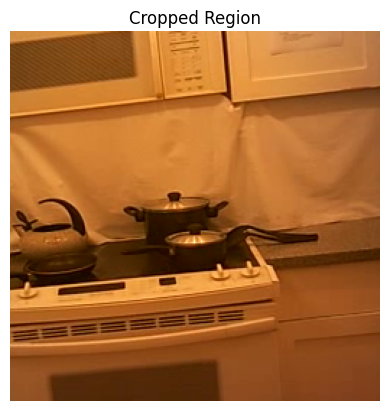

In [99]:
def crop_frame(frame, gaze_x, gaze_y, crop_size, resize=None):
    h, w, _ = frame.shape
    x_center = int(gaze_x * w)
    y_center = int(gaze_y * h)

    # Calculate desired crop boundaries (might be outside frame)
    desired_x1 = x_center - crop_size // 2
    desired_y1 = y_center - crop_size // 2
    desired_x2 = desired_x1 + crop_size
    desired_y2 = desired_y1 + crop_size

    # Calculate how much we're out of bounds on each side
    pad_left = max(0, -desired_x1)
    pad_right = max(0, desired_x2 - w)
    pad_top = max(0, -desired_y1)
    pad_bottom = max(0, desired_y2 - h)

    # Clamp coordinates to actual frame dimensions
    x1 = max(0, desired_x1)
    y1 = max(0, desired_y1)
    x2 = min(w, desired_x2)
    y2 = min(h, desired_y2)

    # Perform the actual crop
    cropped_frame = frame[y1:y2, x1:x2]

    # Apply asymmetric padding only where needed
    if pad_left + pad_right + pad_top + pad_bottom > 0:
        cropped_frame = cv2.copyMakeBorder(
            cropped_frame,
            pad_top, pad_bottom,
            pad_left, pad_right,
            cv2.BORDER_REFLECT
        )

    # Final resize if requested
    if resize and resize != crop_size:
        cropped_frame = cv2.resize(cropped_frame, (resize, resize))

    return cropped_frame

# Define the frame resolution and crop size
camera_fov = 40 # Camera field of view in degrees, this is an estimate, i can't find online what the actual fov is
phosphene_fov = 16

ratio = phosphene_fov / camera_fov 
crop_size = int(frame_width * ratio)
print(crop_size)

if ret:
    cropped = crop_frame(frame, gaze_x, gaze_y, crop_size=crop_size, resize=None)
    print(cropped.shape)

    # Display the cropped region
    plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    plt.title("Cropped Region")
    plt.axis('off')
    plt.show()
else:
    print(f"Error: Could not retrieve frame {frame_i}.")

# Simulator

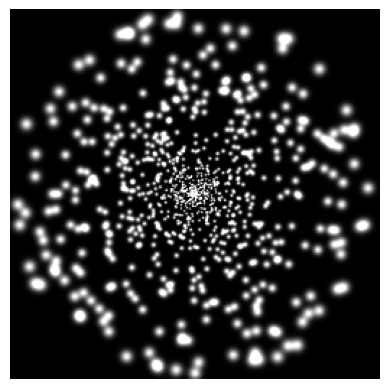

In [100]:
# Load the simulator configuration file (and adjust to preferences).
params = utils.load_params('../config/params.yaml')
params['run']['resolution'] = [crop_size, crop_size]

# Get phosphene coordinates...
n_phosphenes = 1024
phosphene_coords = cortex_models.get_visual_field_coordinates_probabilistically(params, n_phosphenes)

# Initialize simulator
simulator = PhospheneSimulator(params, phosphene_coords)

# Stimulation amplitude
amplitude = params['sampling']['stimulus_scale'] # Ampère (160 µA)

# Stimulation vector
stim = amplitude * torch.ones(n_phosphenes).cuda() # (All electrodes are activated)

# Reset and call the simulator
simulator.reset()
phosphenes = simulator(stim)

# Show the phosphene image
plt.imshow(phosphenes.cpu()[0], cmap='gray')
plt.axis('off')
plt.show()

# Uniformity

Loss = 0.0327:   2%|███████                                                                                                                                                                                                                                                                                             | 48/2000 [00:00<00:08, 233.01iter/s]

Loss = 0.0035: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 232.73iter/s]


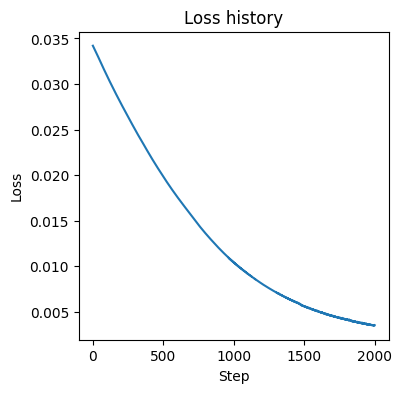

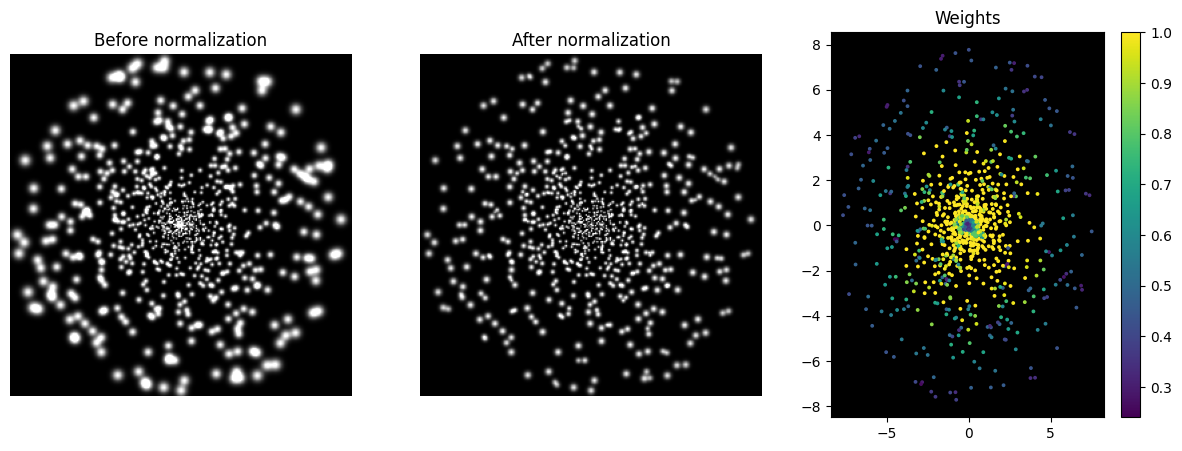

In [101]:
stim_init = amplitude * torch.ones(simulator.num_phosphenes, device='cuda')

normalizer = DynamicAmplitudeNormalizer(
    simulator=simulator,
    base_size=3,
    scale=0.0001,
    A_min=0,
    A_max=amplitude,
    learning_rate=0.002,
    steps=2000,
    target=None  # or a specific float
)
stim_final = normalizer.run(stim_init, verbose=True)
stim_weights = normalizer.weights

# plot the loss_history from the normalizer
plt.figure(figsize=(4, 4))
plt.plot(normalizer.loss_history)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss history')
plt.show()

# Visualize
simulator.reset()
phos_image_before = simulator(stim_init)
simulator.reset()
phos_image_after  = simulator(stim_init * stim_weights)

# visualize the phosphene images and the weights in a scatterplot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(phos_image_before.cpu()[0], cmap='gray')
plt.axis('off')
plt.title('Before normalization')

plt.subplot(1, 3, 2)
plt.imshow(phos_image_after.cpu()[0], cmap='gray')
plt.axis('off')
plt.title('After normalization')

plt.subplot(1, 3, 3)
phosphene_coords = simulator.coordinates
plt.scatter(phosphene_coords._x, phosphene_coords._y, c=stim_weights.cpu(), cmap='viridis', s=3)
# black background
plt.gca().set_facecolor('black')
plt.colorbar()
plt.title('Weights')
plt.show()

# Fov Conv2D LoG Module

In [102]:
def bio_inspired_normalization(electrode, amplitude, threshold, slope):
    """
    Normalize the stimulation values using a shifted exponential function.
    
    The function is defined as:
        S(I) = amplitude * (1 - exp(-slope * (I - threshold)_+))
    
    where (I - threshold)_+ = max(I - threshold, 0).
    
    This ensures that values below threshold remain near 0 (since no phosphene is activated)
    and above threshold the response increases nonlinearly, saturating toward amplitude.
    
    Args:
      electrode: torch.Tensor of stimulation values.
      amplitude: float, the maximum amplitude (target) to be reached.
      threshold: float, the activation threshold.
      slope: float, controlling the steepness of the nonlinearity.
      
    Returns:
      normalized: torch.Tensor with the same shape as electrode.
    """
    # Compute the positive part (I - threshold)_+
    diff = electrode - threshold
    diff = torch.clamp(diff, min=0.0)
    
    # Apply the shifted exponential nonlinearity.
    normalized = amplitude * (1.0 - torch.exp(-slope * diff))
    return normalized


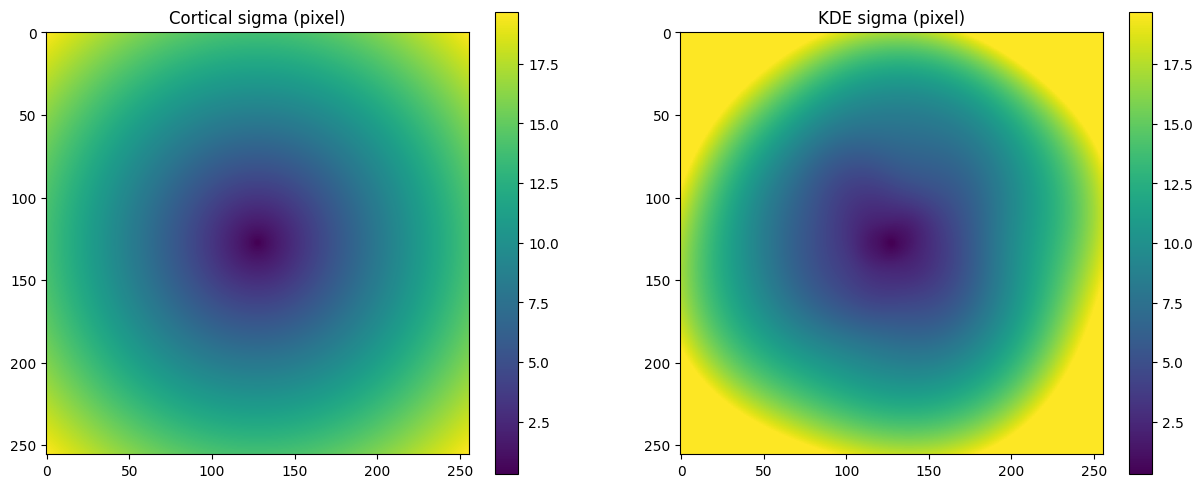

In [103]:
mapper = VisualFieldMapper(simulator=simulator)

# 1) Cortical approach:
density_cortical = mapper.build_density_map_cortical(total_phosphenes=1024)
sigma_cortical_pix = mapper.build_sigma_map_from_density(density_cortical, space="pixel")

# 2) KDE approach:
density_kde = mapper.build_density_map_kde(k=32, alpha=1.0, total_phosphenes=1024)
sigma_kde_pix = mapper.build_sigma_map_from_density(density_kde, space="pixel")

# show density maps
fov = params['run']['view_angle']

# plot sigma_cortical_pix, sigma_kde_pix

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(sigma_cortical_pix, cmap='viridis')
plt.colorbar()
plt.title('Cortical sigma (pixel)')

plt.subplot(1, 2, 2)
plt.imshow(sigma_kde_pix, cmap='viridis', vmax=sigma_cortical_pix.max())
plt.colorbar()
plt.title('KDE sigma (pixel)')
plt.show()

In [104]:
sigma_map_tensor = torch.Tensor(sigma_kde_pix).float().cuda().detach()

layer = SeparableModulatedConv2d(
    in_channels=1,
    sigma_map=sigma_map_tensor).cuda()

In [105]:
def robust_percentile_normalization(electrode, amplitude, threshold, low_perc=5, high_perc=95, gamma=1.0):
    """
    Normalize the stimulation vector in a robust, contrast-preserving way.

    This function performs the following steps:
      1. Subtracts a given threshold (values below threshold become 0).
      2. Computes low and high percentiles (e.g., 5th and 95th) of the resulting values.
      3. Linearly scales values between these percentiles to [0, 1], then applies an optional gamma correction.
      4. Scales the result to the desired amplitude.

    Args:
        electrode (torch.Tensor): Input stimulation values.
        amplitude (float): Desired maximum amplitude.
        threshold (float): Activation threshold (e.g. your activation_threshold).
        low_perc (float): Lower percentile (default 5).
        high_perc (float): Upper percentile (default 95).
        gamma (float): Gamma exponent for power-law scaling (default 1.0 means linear scaling).
        
    Returns:
        torch.Tensor: Normalized stimulation values, with zeros preserved.
    """
    # Subtract threshold and clamp to 0 so that values below threshold remain 0.
    above_thresh = electrode - threshold
    above_thresh = torch.clamp(above_thresh, min=0.0)
    
    # Compute robust lower and upper bounds using percentiles.
    # Use torch.quantile (available in PyTorch 1.7+; adjust if needed).
    low_val = torch.quantile(above_thresh, low_perc / 100.0)
    high_val = torch.quantile(above_thresh, high_perc / 100.0)
    
    # Avoid division by zero if high_val == low_val.
    range_val = high_val - low_val + 1e-8

    # Linearly map values in the range [low_val, high_val] to [0, 1]
    normalized = (above_thresh - low_val) / range_val
    normalized = torch.clamp(normalized, 0.0, 1.0)

    # Apply gamma correction to adjust contrast if needed.
    normalized = normalized ** gamma

    # Scale to the desired amplitude.
    normalized = normalized * amplitude

    return normalized


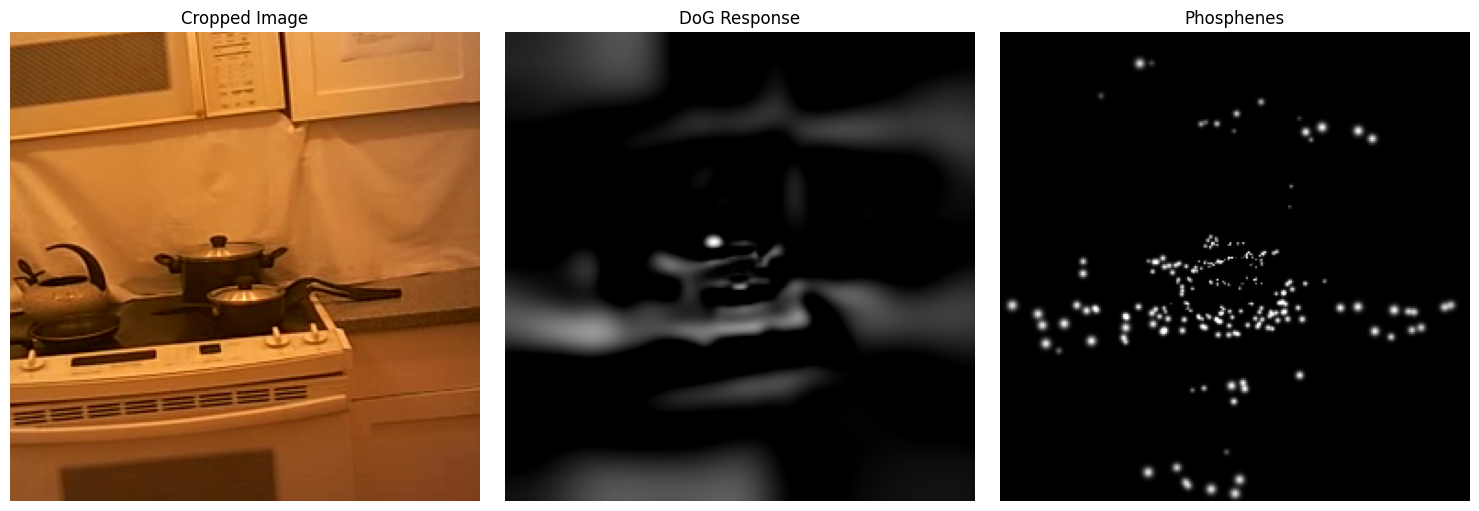

In [106]:
from torchvision import transforms
import matplotlib.pyplot as plt

def crop_around_gaze(image, gaze_x, gaze_y, crop_w, crop_h):
    """
    Crop a region centered around gaze from the input image.
    Handles edge cropping if the gaze is near the border.
    """
    H, W = image.shape[:2]
    x_center = int(gaze_x * W)
    y_center = int(gaze_y * H)

    x1 = max(0, x_center - crop_w // 2)
    y1 = max(0, y_center - crop_h // 2)
    x2 = min(W, x1 + crop_w)
    y2 = min(H, y1 + crop_h)

    # Adjust to always get exact crop size (if near borders)
    x1 = max(0, x2 - crop_w)
    y1 = max(0, y2 - crop_h)

    return image[y1:y2, x1:x2]


# 0) Start with your OpenCV crop as before: BGR in [0,1]
#    Call it `cropped`: shape (H, W, 3)
gaze_x, gaze_y = gaze_point[0], gaze_point[1]  # Normalized coordinates
crop_size = int(frame_width * ratio)  
orig_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert to RGB
cropped = crop_around_gaze(orig_rgb, gaze_x, gaze_y, crop_size, crop_size)

# 1) Compute weighted‐luma manually
#    (we need a 1-channel tensor for the new module)
rgb_w = torch.tensor([0.2126, 0.7152, 0.0722], device='cuda')
# convert to tensor [3,H,W]
img_t = torch.from_numpy(cropped.transpose(2,0,1)).float().cuda()
# weighted sum over channel → [H,W]
luma2d = (rgb_w.view(3,1,1) * img_t).sum(dim=0)
# add batch & channel dims → [1,1,H,W]
image_tensor = luma2d.unsqueeze(0).unsqueeze(0)

# 2) Run your module (now single‐channel)
with torch.no_grad():
    response = layer(image_tensor).clamp(min=0)
response = (response - response.min()) / (response.max() - response.min())
response_disp = response[0,0].cpu().numpy()  # [H,W]

# 3) Stimulate / threshold / simulate
simulator.reset()
electrodes = simulator.sample_stimulus(response, rescale=True)
electrodes = robust_percentile_normalization(
    electrodes, amplitude,
    threshold=params['thresholding']['rheobase'],
    low_perc=5, high_perc=90, gamma=2/3
)
phos = simulator(electrodes * stim_weights)  # [1,1,H,W]
phos_disp = phos[0].cpu().numpy()          # [H,W]

# 4) Plot all three side by side
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(cropped)               # full‐color RGB
plt.title('Cropped Image')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(response_disp, cmap='gray')
plt.title('DoG Response')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(phos_disp, cmap='gray')
plt.title('Phosphenes')
plt.axis('off')

plt.tight_layout()
plt.show()


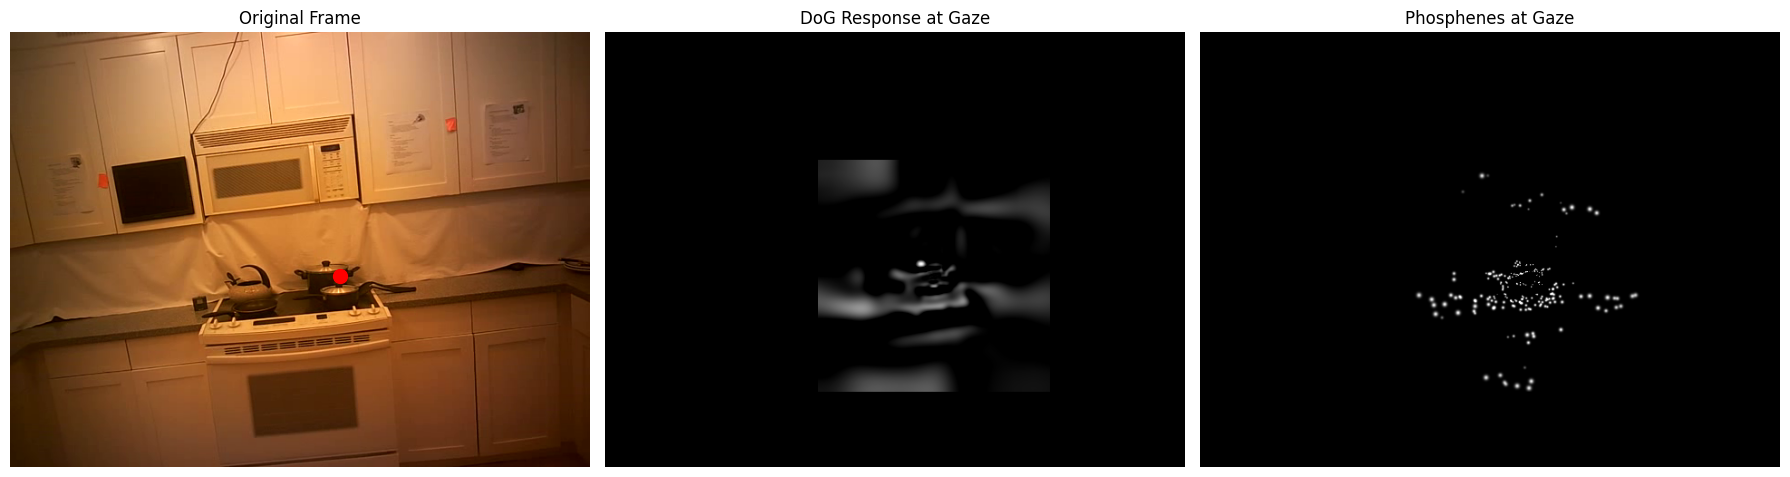

In [107]:
def insert_patch_on_black_canvas(frame_shape, patch, gaze_x, gaze_y):
    """
    Create a black canvas the size of `frame_shape`, and place `patch` at a location
    specified by the normalized gaze_x, gaze_y.

    Inputs:
    - frame_shape: (H, W, C) for RGB or (H, W) for grayscale
    - patch:       (h, w) or (h, w, c)
    - gaze_x, gaze_y: normalized coordinates in [0,1]

    Returns:
    - canvas: image with patch placed on black background
    """
    canvas = np.zeros(frame_shape, dtype=patch.dtype)
    
    H, W = frame_shape[:2]
    h, w = patch.shape[:2]

    # Center coordinates
    x_center = int(gaze_x * W)
    y_center = int(gaze_y * H)

    # Target region
    x1 = max(0, x_center - w // 2)
    y1 = max(0, y_center - h // 2)
    x2 = min(W, x1 + w)
    y2 = min(H, y1 + h)

    # Source region
    patch_x1 = 0
    patch_y1 = 0
    patch_x2 = x2 - x1
    patch_y2 = y2 - y1

    if patch.ndim == 2 and canvas.ndim == 3:
        canvas[y1:y2, x1:x2, :] = patch[patch_y1:patch_y2, patch_x1:patch_x2, None]
    else:
        canvas[y1:y2, x1:x2] = patch[patch_y1:patch_y2, patch_x1:patch_x2]

    return canvas

# Resize to smaller patch
Hc, Wc = 256, 256  # or whatever your patch size is
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
response_disp = cv2.resize(response_disp, (Wc, Hc))
phos_disp = cv2.resize(phos_disp, (Wc, Hc))

resp_patch = cv2.resize(response_disp, (Wc, Hc))
phos_patch = cv2.resize(phos_disp, (Wc, Hc))

# Convert to uint8 grayscale
resp_u8 = (resp_patch * 255).astype(np.uint8)
phos_u8 = (phos_patch * 255).astype(np.uint8)

# Insert on black canvas
frame_shape = frame_rgb.shape if frame_rgb.ndim == 3 else frame_rgb.shape + (1,)
canvas_resp = insert_patch_on_black_canvas(frame_shape, resp_u8, gaze_x, gaze_y)
canvas_phos = insert_patch_on_black_canvas(frame_shape, phos_u8, gaze_x, gaze_y)


plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(frame_rgb)
plt.scatter(gaze_x * frame_rgb.shape[1], gaze_y * frame_rgb.shape[0], color='red', s=100)
plt.title("Original Frame")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(canvas_resp[:, :, ::-1] if canvas_resp.ndim == 3 else canvas_resp, cmap="gray")
plt.title("DoG Response at Gaze")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(canvas_phos[:, :, ::-1] if canvas_phos.ndim == 3 else canvas_phos, cmap="gray")
plt.title("Phosphenes at Gaze")
plt.axis("off")

plt.tight_layout()
plt.show()


# Smooth Gaze Data for blinks

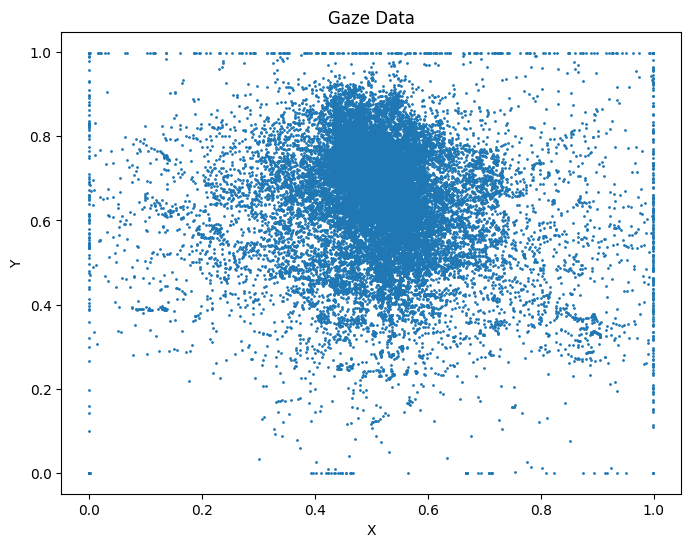

In [108]:
# plot eye gaze data
plt.figure(figsize=(8, 6))
# scatterplot x,y gaze data
plt.scatter(gaze_data[:,0], gaze_data[:,1], s=1)
plt.title('Gaze Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [109]:
blink_epsilon = 0.05
# find blinks where x or y is less than epsilon or more than 1-epsilon
blink_indices = np.where(
    (gaze_data[:,0] < blink_epsilon) | (gaze_data[:,0] > 1-blink_epsilon) |
    (gaze_data[:,1] < blink_epsilon) | (gaze_data[:,1] > 1-blink_epsilon)
)[0]

# n many blnks found
print(len(blink_indices), 'blinks found')

3582 blinks found


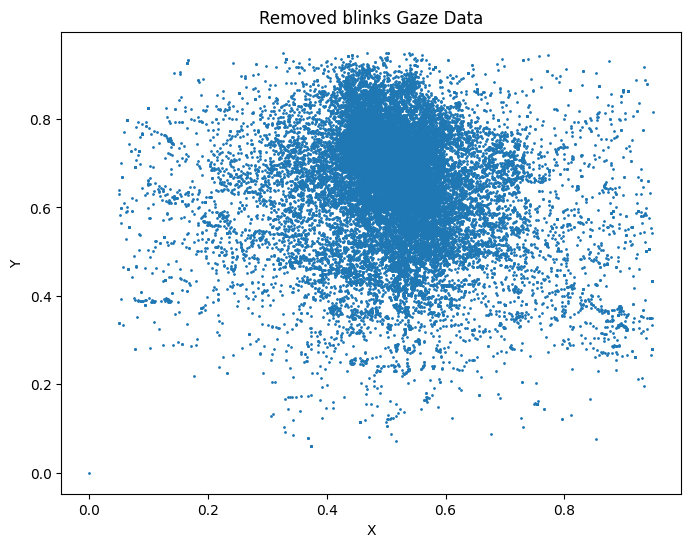

In [110]:
# wherever the blink is, set the gaze point to the last valid gaze point
removed_blinks_gaze_data = gaze_data.copy()
for i in blink_indices:
    removed_blinks_gaze_data[i] = removed_blinks_gaze_data[i-1]

# plot eye gaze data
plt.figure(figsize=(8, 6))
# scatterplot x,y gaze data
plt.scatter(removed_blinks_gaze_data[:,0], removed_blinks_gaze_data[:,1], s=1)
plt.title('Removed blinks Gaze Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


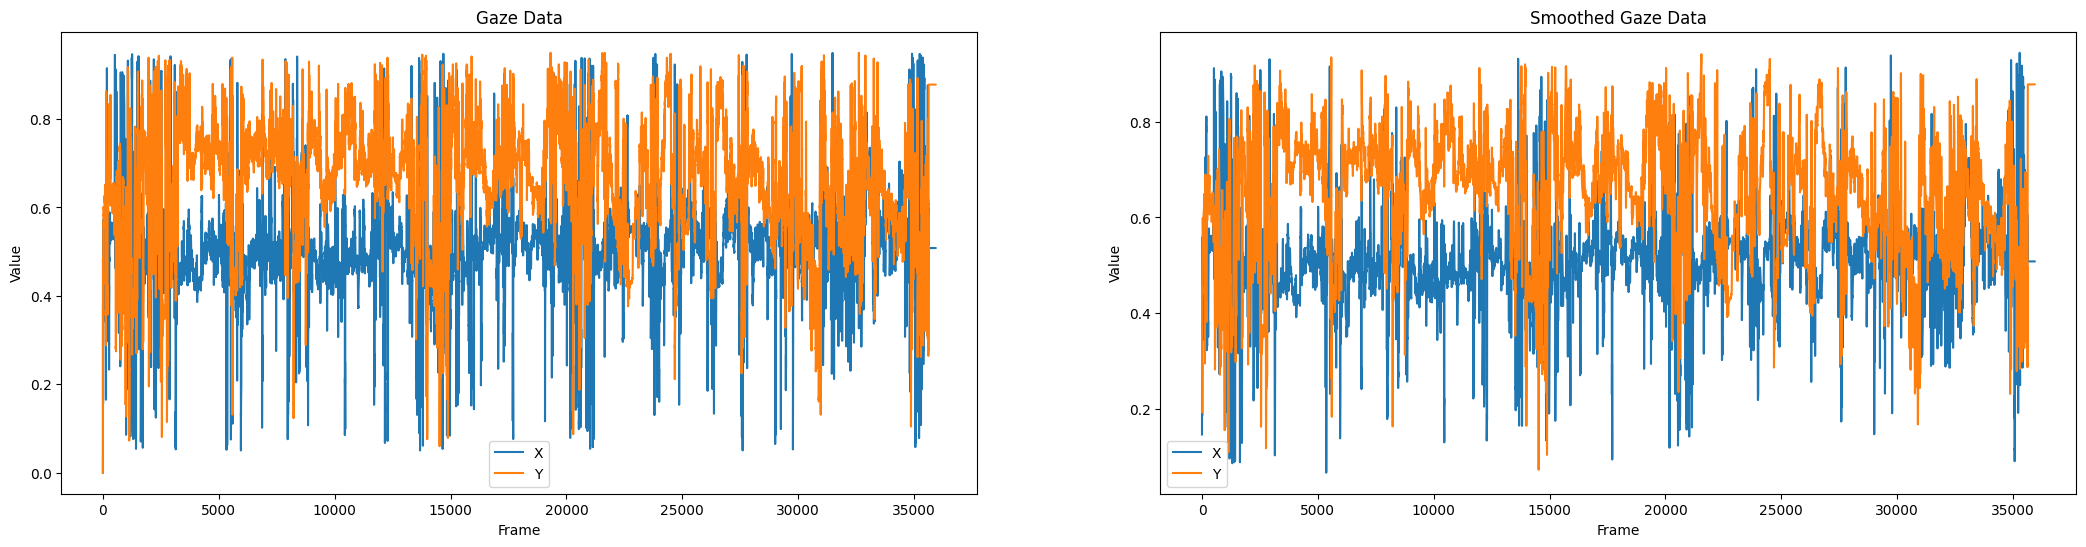

In [111]:
# smooth the first 2 columns of the gaze data
smoothed_gaze_data = removed_blinks_gaze_data.copy()

sigma = 2  # Adjust sigma based on desired smoothness
# Apply Gaussian smoothing to both X and Y coordinates
smoothed_gaze_data[:,0] = gaussian_filter1d(removed_blinks_gaze_data[:,0], sigma=sigma, mode='nearest')
smoothed_gaze_data[:,1] = gaussian_filter1d(removed_blinks_gaze_data[:,1], sigma=sigma, mode='nearest')


# plot eye gaze data
plt.figure(figsize=(26, 6))
# scatterplot x,y gaze data

plt.subplot(1, 2, 1)
plt.plot(removed_blinks_gaze_data[:,0], label='X')
plt.plot(removed_blinks_gaze_data[:,1], label='Y')
plt.title('Gaze Data')
plt.xlabel('Frame')
plt.ylabel('Value')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(smoothed_gaze_data[:,0], label='X')
plt.plot(smoothed_gaze_data[:,1], label='Y')
plt.title('Smoothed Gaze Data')
plt.xlabel('Frame')
plt.ylabel('Value')
plt.legend()
plt.show()



# Video processing

In [112]:
import cv2
import numpy as np
import torch
from torchvision import transforms

file_name = "OP01-R01-PastaSalad"
gaze_data_path = f"../data/EGTEA/Gaze_Data/gaze_data/gaze_data/{file_name}.txt"
video_path = f"../data/EGTEA/Raw_Videos/{file_name}.mp4"
out_path = f"../out/{file_name}_shiftvariantDoG_temporalDynamics_50sec.mp4"

stack = 'horizontal'  # or 'vertical'
start_time_sec = 25
video_duration_sec = 50

cap = cv2.VideoCapture(video_path)
actual_fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

frame_nr_start = int(start_time_sec * actual_fps)
max_n_frames = int((start_time_sec + video_duration_sec) * actual_fps)
max_n_frames = min(max_n_frames, total_frames)

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out_shape = (3 * frame_width, frame_height) if stack == 'horizontal' else (frame_width, 3 * frame_height)
out = cv2.VideoWriter(out_path, fourcc, actual_fps, out_shape, isColor=True)

cap.set(cv2.CAP_PROP_POS_FRAMES, frame_nr_start)
current_frame = frame_nr_start

simulator.reset()

while current_frame < max_n_frames:
    ret, frame = cap.read()
    if not ret:
        break

    gaze_point = smoothed_gaze_data[current_frame, :]
    if gaze_point[2] == 4:
        current_frame += 1
        continue

    gaze_x, gaze_y = gaze_point[0], gaze_point[1]
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert to RGB
    cropped = crop_frame(frame, gaze_x, gaze_y, crop_size=crop_size, resize=None)

    # Convert cropped BGR to RGB and compute grayscale (luma)
    rgb = cropped[..., ::-1] / 255.0
    rgb_tensor = torch.from_numpy(rgb.transpose(2, 0, 1)).float().cuda()
    rgb_weights = torch.tensor([0.2126, 0.7152, 0.0722], device='cuda').view(3, 1, 1)
    grayscale = (rgb_tensor * rgb_weights).sum(dim=0).unsqueeze(0).unsqueeze(0)

    with torch.no_grad():
        response = layer(grayscale).clamp(min=0)
    response = (response - response.min()) / (response.max() - response.min())
    response_disp = response[0, 0].cpu().numpy()

    # simulator.reset() # Turn off for temporal dynamics
    electrodes = simulator.sample_stimulus(response, rescale=True)
    electrodes = robust_percentile_normalization(
        electrodes, amplitude,
        threshold=params['thresholding']['rheobase'],
        low_perc=5, high_perc=90, gamma=2/3
    )
    phosphenes = simulator(electrodes * stim_weights)[0].cpu().numpy()

    # Overlay on black canvas at gaze position
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    canvas_shape = frame_rgb.shape[:2]
    resp_u8 = (response_disp * 255).astype(np.uint8)
    phos_u8 = (phosphenes * 255).astype(np.uint8)

    canvas_resp = insert_patch_on_black_canvas(canvas_shape, resp_u8, gaze_x, gaze_y)
    canvas_phos = insert_patch_on_black_canvas(canvas_shape, phos_u8, gaze_x, gaze_y)

    # Convert grayscale overlays to RGB if needed
    canvas_resp = np.stack([canvas_resp]*3, axis=-1) if canvas_resp.ndim == 2 else canvas_resp
    canvas_phos = np.stack([canvas_phos]*3, axis=-1) if canvas_phos.ndim == 2 else canvas_phos

    # Draw gaze point
    gaze_px = (int(gaze_x * frame_width), int(gaze_y * frame_height))
    cv2.circle(frame_rgb, gaze_px, 10, (255, 0, 0), -1)

    # Concatenate and write
    if stack == 'horizontal':
        cat = np.concatenate([frame_rgb, canvas_resp, canvas_phos], axis=1)
    else:
        cat = np.concatenate([frame_rgb, canvas_resp, canvas_phos], axis=0)

    out.write(cat.astype(np.uint8))
    current_frame += 1

cap.release()
out.release()
cv2.destroyAllWindows()